In [2]:
from scipy.signal import stft, windows
import numpy as np
import os
import pickle
import glob
import pandas as pd
import matplotlib.pyplot as plt
import re

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

nfft = 512

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

def STFT(st,nfft=512):
    winlen = 64
    _, _, Zxx = stft(st, fs=1024, window = windows.hamming(winlen), nperseg=winlen, nfft=nfft ,noverlap=winlen-1, boundary='zeros', return_onesided=False)
    return np.fft.fftshift(Zxx,axes=0)

def awgn(signal, snr):
      
    # Calculate signal power and convert SNR to linear scale
    signal_power = np.mean(np.abs(signal)**2)
    snr_linear = 10**(snr / 10)
    
    # Calculate noise power and generate complex noise
    noise_power = signal_power / snr_linear
    noise_real = np.random.normal(0, np.sqrt(noise_power / 2), signal.shape)
    noise_imag = np.random.normal(0, np.sqrt(noise_power / 2), signal.shape)
    noise = noise_real + 1j * noise_imag
    
    # Add noise to the signal
    signal_with_noise = signal + noise
    
    return signal_with_noise

cuda


In [29]:
# # Create ECHO Dataset
# def extract_data(directory):
#     data = []
#     label = []
#     for class_folder in os.listdir(directory):
#         class_path = os.path.join(directory, class_folder)
#         if os.path.isdir(class_path):
#             for filename in os.listdir(class_path):
#                 if filename.endswith(".pkl"):
#                     file_path = os.path.join(class_path, filename)
#                     with open(file_path, 'rb') as file:
#                         item = pickle.load(file)
#                         data.append(item['echo']['HH'])
#                         label.append(item['target_id'])
#     return np.array(data), np.array(label)

# # # 
# base_dir = '../../Dataset'
# train_dir = os.path.join(base_dir, 'train')
# test_dir = os.path.join(base_dir, 'test')

# # Load data
# train_data,train_label = extract_data(train_dir)
# test_data,test_label = extract_data(test_dir)

# np.save('train_data.npy',train_data)
# np.save('train_label.npy',train_label)
# np.save('test_data.npy',test_data)
# np.save('test_label.npy',test_label)

In [30]:
data = {}
for data_dir in glob.glob('*.npy'):
    data[re.match(r"(.*)\.npy", data_dir).group(1)] = np.load(data_dir)

In [46]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

# Define the transfer function
def transfer(data, snr, seed):
    np.random.seed(seed)
    x = np.array([complex(x) for x in data])
    x = awgn(x, snr)
    Tfr = np.abs(STFT(x))
    return Tfr

# Define a function to sample 500 examples from each class
def sample_data(data, labels, num_samples=500):
    unique_classes = np.unique(labels)
    sampled_data = []
    sampled_labels = []
    
    for cls in unique_classes:
        cls_indices = np.where(labels == cls)[0]
        sampled_indices = np.random.choice(cls_indices, num_samples, replace=False)
        sampled_data.append(data[sampled_indices])
        sampled_labels.append(labels[sampled_indices])
    
    return np.concatenate(sampled_data), np.concatenate(sampled_labels)

# Custom dataset class
class TimeSeriesDataset(Dataset):
    def __init__(self, data, label, sample=False, num_samples_per_class=1000):
        if sample:
            sampled_data, sampled_labels = sample_data(data, label, num_samples_per_class)
            self.datas = sampled_data
            self.labels = sampled_labels
        else:
            self.datas = data
            self.labels = label

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, idx):
        x = self.datas[idx]
        x = transfer(x, snr=20, seed=idx)
        y = self.labels[idx]
        return torch.tensor(x[:, :512], dtype=torch.float32).to(device), torch.tensor(y, dtype=torch.long).to(device)

# Assuming `data` is a dictionary with 'train_data' and 'train_label' keys
train_dataset = TimeSeriesDataset(data['train_data'], data['train_label'], sample=True)
test_dataset = TimeSeriesDataset(data['test_data'], data['test_label'], sample=False)

train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False)

# Example usage: Print the number of samples in the training set
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

Number of training samples: 4000
Number of test samples: 1600


4000
label is 1.


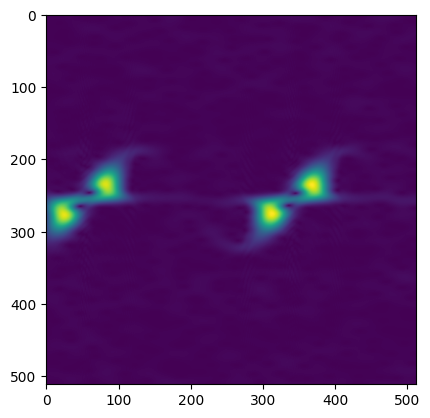

In [47]:
print(train_dataset.__len__())
idx = 1200
plt.imshow(train_dataset.__getitem__(idx)[0].cpu().numpy());
print(f'label is {train_dataset.__getitem__(idx)[1].cpu().numpy()}.')

In [48]:
# CNN-II from Recognition of Micro-Motion Space Targets Based on Attention-Augmented Cross-Modal Feature Fusion Recognition Network used to extract JTF features.

class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        # Define the layers as shown in the diagram
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=8, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(16)
        self.dropout1 = nn.Dropout2d(0.5)
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=8, stride=1, padding=0)
        self.bn2 = nn.BatchNorm2d(32)
        self.dropout2 = nn.Dropout2d(0.5)
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(64)
        
        self.fc1 = nn.Linear(222784, 128)  # Adjust dimensions based on your input size
        self.dropout3 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(128, 4)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout1(x)
        x = F.max_pool2d(x, 2)

        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.dropout2(x)
        x = F.max_pool2d(x, 2)

        
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        
        x = x.view(-1, 222784)  
        # x = F.relu(self.fc1(x))
        x = self.fc1(x)
        x = self.dropout3(x)
        
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [49]:
model = CNN2().to(device)

In [50]:
def train(dataloader, loss_fn, optimizer):
    total_acc, total_count, total_loss, = 0, 0, 0
    model.train()
    for series, label in dataloader:
        predicted_label = model(series.unsqueeze(1))
        loss = loss_fn(predicted_label, label)
        # Back-propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            total_acc += (predicted_label.argmax(1) == label).sum().item()  # predict true
            total_count += label.size(0)
            total_loss += loss.item()*label.size(0)
    return total_loss/total_count, total_acc/total_count

def test(dataloader, loss_fn):
    model.eval()
    total_acc, total_count, total_loss, = 0, 0, 0

    with torch.no_grad():
        for series, label in dataloader:
            predicted_label = model(series.unsqueeze(1))
            loss = loss_fn(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
            total_loss += loss.item()*label.size(0)
    return total_loss/total_count, total_acc/total_count

def fit(epochs, train_dl, test_dl, loss_fn, optimizer):
    train_loss = [] 
    train_acc = []
    test_loss = []
    test_acc = []

    for epoch in range(epochs):
        
        epoch_loss, epoch_acc = train(train_dl, loss_fn, optimizer)
        epoch_test_loss, epoch_test_acc = test(test_dl, loss_fn)
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)
        test_loss.append(epoch_test_loss)
        test_acc.append(epoch_test_acc)

        template = ("epoch:{:2d}, train_loss: {:.5f}, train_acc: {:.1f}% ," 
                    "test_loss: {:.5f}, test_acc: {:.1f}%")
        if epoch%10 ==0:
            print(template.format(
                epoch, epoch_loss, epoch_acc*100, epoch_test_loss, epoch_test_acc*100))


In [51]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), betas=(0.5, 0.5), lr=0.001)

EPOCHS = 100
train_loss, test_loss, train_acc, test_acc = fit(EPOCHS, train_loader, test_loader, loss_fn, optimizer)

epoch: 0, train_loss: 15.22546, train_acc: 37.5% ,test_loss: 1.49215, test_acc: 31.4%
epoch:10, train_loss: 1.20350, train_acc: 48.2% ,test_loss: 1.13799, test_acc: 43.6%
epoch:20, train_loss: 1.20312, train_acc: 51.6% ,test_loss: 1.28501, test_acc: 33.2%
epoch:30, train_loss: 1.42614, train_acc: 33.6% ,test_loss: 1.35739, test_acc: 30.4%


KeyboardInterrupt: 